# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [187]:
# Optional, if using Google Colab w/ Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)



In [197]:
import cv2

import numpy as np
import IPython
from matplotlib.colors import LogNorm
from scipy import signal

# modify to where you store your project data including utils.py
datadir = "./" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
import utils

cp: ./utils.py and ./utils.py are identical (not copied).


In [198]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib inline
import matplotlib.pyplot as plt


## 1. The Original Images

Text(0.5, 1.0, 'Image 2')

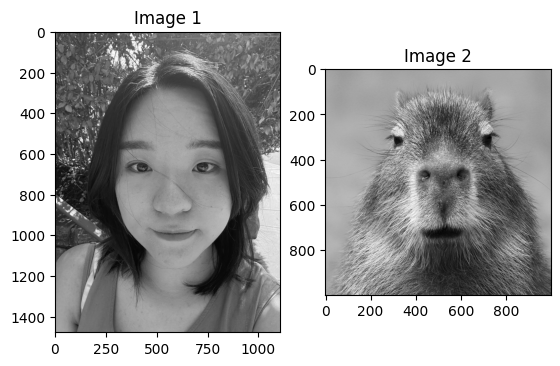

In [350]:
im1_file = datadir + 'vivian.jpg'
im2_file = datadir + 'capybara.jpg'

# read images in gray scale
im1_grayscale = cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE)
im2_grayscale = cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE)
if im1_grayscale is None or im2_grayscale is None:
    exit()

# normalize images
im1 = np.float32(im1_grayscale / 255.0)
im2 = np.float32(im2_grayscale / 255.0)

# plot the two images
figs, axes = plt.subplots(1, 2)
axes[0].imshow(im1, cmap="gray")
axes[0].set_title("Image 1")
axes[1].imshow(im2, cmap="gray")
axes[1].set_title("Image 2")

## 2. Image Alignment with Eye Coordinates

Text(0.5, 1.0, 'Image 2')

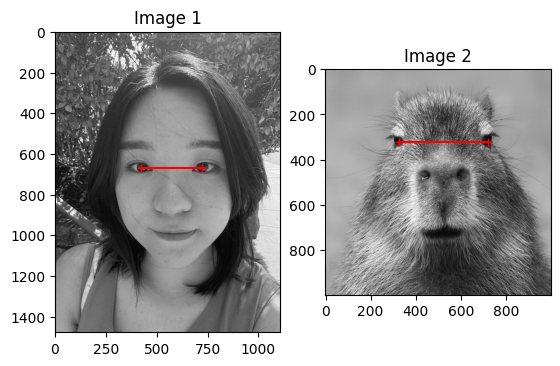

In [352]:
# Fetch the coordinates of eyes in the two images
pts_im1 = np.array([[422, 670], [721,670]]) 
pts_im2 = np.array([[326, 320], [719, 320]]) # uncomment if entering [x, y] pts manually

fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1, cmap="gray")
axes[0].plot(pts_im1[:, 0], pts_im1[:, 1], 'r-+')
axes[0].set_title("Image 1")
axes[1].imshow(im2, cmap="gray")
axes[1].plot(pts_im2[:, 0], pts_im2[:, 1], 'r-+')
axes[1].set_title("Image 2")

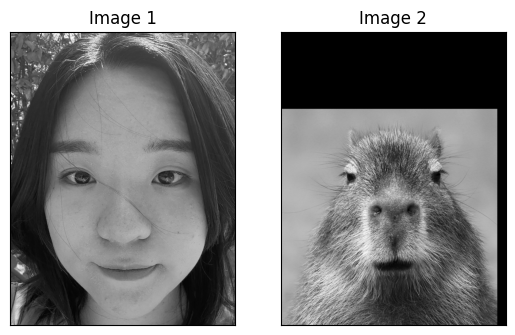

In [392]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([]);

## 3. Generate Hybrid Image

In [ ]:
def get_2d_gaussian(sigma: int):
    width = 6
    ksize = int(np.ceil(sigma) * width + 1)
    fil = cv2.getGaussianKernel(ksize, sigma)
    fil_2d = fil @ fil.T
    return fil_2d / fil_2d.sum()

def hybridImage(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  
    # filters for im1 and im2
    G_low = get_2d_gaussian(sigma_low)
    G_high = get_2d_gaussian(sigma_high)

    # Apply filters for im1 and im2
    filtered_im_low = cv2.filter2D(im1, -1, G_low)
    filtered_im_high = im2 - cv2.filter2D(im2, -1, G_high)
    print(f"{filtered_im_low}")

    return filtered_im_low + filtered_im_high
      


[[0.44625633 0.44609974 0.44563311 ... 0.4800744  0.48044663 0.48057203]
 [0.4461995  0.44604292 0.44557635 ... 0.48019501 0.480569   0.48069499]
 [0.44602574 0.44586919 0.44540279 ... 0.48055225 0.48093151 0.48105925]
 ...
 [0.63011705 0.63016062 0.63026736 ... 0.32665325 0.32678042 0.32682279]
 [0.63024404 0.63028505 0.63038387 ... 0.32640368 0.32653595 0.32658006]
 [0.63028807 0.63032823 0.63042441 ... 0.32631965 0.32645367 0.32649837]]


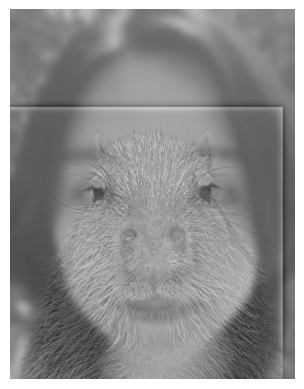

In [396]:
# Create hybrid images set sigmas for hybrid images 
sigma_low = 10 # choose parameters that work for your images
sigma_high = 30
im_hybrid = hybridImage(im1, im2, sigma_low, sigma_high)

# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

## Frequency Plot 

- Plot low-pass filter and high-pass filter to ensure that they do not have strong overlap.
- As demonstrated below, there is a gap between the two filters when the gain equals $0.5$. Therefore, the hybrid image can form unambiguous interpretations when viewing from different distances away.

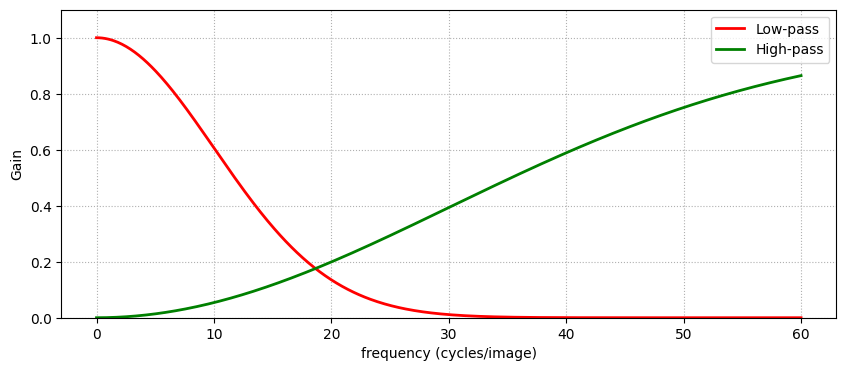

In [376]:
import numpy as np
# Define frequency axis
f = np.linspace(0, 60, 500)  # cycles/image

# Low-pass Gaussian response
H_low = np.exp(-(f**2) / (2 * sigma_low**2))

# High-pass response
H_high = 1 - np.exp(-(f**2) / (2 * sigma_high**2))

# Plot
plt.figure(figsize=(10,4))
plt.plot(f, H_low, 'r', linewidth=2, label="Low-pass")
plt.plot(f, H_high, 'g', linewidth=2, label="High-pass")
plt.xlabel("frequency (cycles/image)")
plt.ylabel("Gain")
plt.ylim(0,1.1)
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

#### Color enhancement 

#### Color shift